In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from diffusers import UNet2DModel, DDPMScheduler
from PIL import Image
import matplotlib.pyplot as plt
import random
from torchvision.models import vgg19


In [33]:
class CustomDataset(Dataset):
    def __init__(self, comp_dir, lg_dir, transform=None):
        self.comp_dir = comp_dir
        self.lg_dir = lg_dir
        self.transform = transform
        self.file_names = [f for f in os.listdir(comp_dir) if os.path.isfile(os.path.join(comp_dir, f))]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        comp_image = Image.open(os.path.join(self.comp_dir, self.file_names[idx])).convert('L')
        lg_image = Image.open(os.path.join(self.lg_dir, self.file_names[idx])).convert('L')

        if self.transform:
            comp_image = self.transform(comp_image)
            lg_image = self.transform(lg_image)

        return comp_image, lg_image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

comp_dir = '/Selected_Comp'
lg_dir = '/Selected_LG'
dataset = CustomDataset(comp_dir, lg_dir, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [37]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()

        for x in range(2):
            self.slice1.add_module(str(x), vgg[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg[x])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Convert grayscale to 3-channel by repeating the grayscale image
        x = x.repeat(1, 3, 1, 1)
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        return [h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3]


In [40]:
class ImageToImageDDPM(pl.LightningModule):
    def __init__(self, l1_weight=1.0, perceptual_weight=0.1):
        super(ImageToImageDDPM, self).__init__()
        self.generator = UNet2DModel(
            sample_size=(64, 2048),
            in_channels=2,  # Two channels: one for the noisy image, one for the condition image
            out_channels=1,  # Single channel output for grayscale images
            layers_per_block=3,
            block_out_channels=(64, 128, 256, 512, 1024),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.criterion_l1 = nn.L1Loss()
        self.criterion_perceptual = PerceptualLoss()
        self.l1_weight = l1_weight
        self.perceptual_weight = perceptual_weight

    def forward(self, x, t, condition):
        condition = resize(condition, x.shape[2:])
        combined_input = torch.cat([x, condition], dim=1)
        return self.generator(combined_input, t).sample

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        comp_images, lg_images = batch
        t = torch.randint(0, self.scheduler.config.num_train_timesteps, (comp_images.size(0),), device=self.device).long()
        noise = torch.randn_like(lg_images).to(self.device)
        noisy_images = self.scheduler.add_noise(lg_images, noise, t)
        denoised_images = self(noisy_images, t, comp_images)

        l1_loss = self.criterion_l1(denoised_images, lg_images)
        perceptual_loss = self.calculate_perceptual_loss(denoised_images, lg_images)
        loss = self.l1_weight * l1_loss + self.perceptual_weight * perceptual_loss
        self.log('train_loss', loss)
        self.log('l1_loss', l1_loss)
        self.log('perceptual_loss', perceptual_loss)

        # Print intermediate results every 100 batches
        if batch_idx % 100 == 0:
            self.print_intermediate_results(noisy_images, denoised_images, lg_images)

        return loss

    def calculate_perceptual_loss(self, denoised_images, target_images):
        denoised_features = self.criterion_perceptual(denoised_images)
        target_features = self.criterion_perceptual(target_images)
        perceptual_loss = sum([self.criterion_l1(denoised, target) for denoised, target in zip(denoised_features, target_features)])
        return perceptual_loss

    def print_intermediate_results(self, noisy_images, denoised_images, lg_images):
        noisy_images = (noisy_images + 1) / 2  # Convert from [-1, 1] to [0, 1]
        denoised_images = (denoised_images + 1) / 2
        lg_images = (lg_images + 1) / 2

        fig, axs = plt.subplots(3, 1, figsize=(20, 10))

        axs[0].imshow(noisy_images[0].cpu().detach().squeeze(), cmap='gray')
        axs[0].set_title('Noisy Image')
        axs[0].axis('off')

        axs[1].imshow(denoised_images[0].cpu().detach().squeeze(), cmap='gray')
        axs[1].set_title('Denoised Image')
        axs[1].axis('off')

        axs[2].imshow(lg_images[0].cpu().detach().squeeze(), cmap='gray')
        axs[2].set_title('Target Image')
        axs[2].axis('off')

        plt.show()


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params | Mode 
----------------------------------------------------------------
0 | generator            | UNet2DModel    | 290 M  | train
1 | criterion_l1         | L1Loss         | 0      | train
2 | criterion_perceptual | PerceptualLoss | 12.9 M | train
----------------------------------------------------------------
290 M     Trainable params
12.9 M    Non-trainable params
303 M     Total params
1,213.026 Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

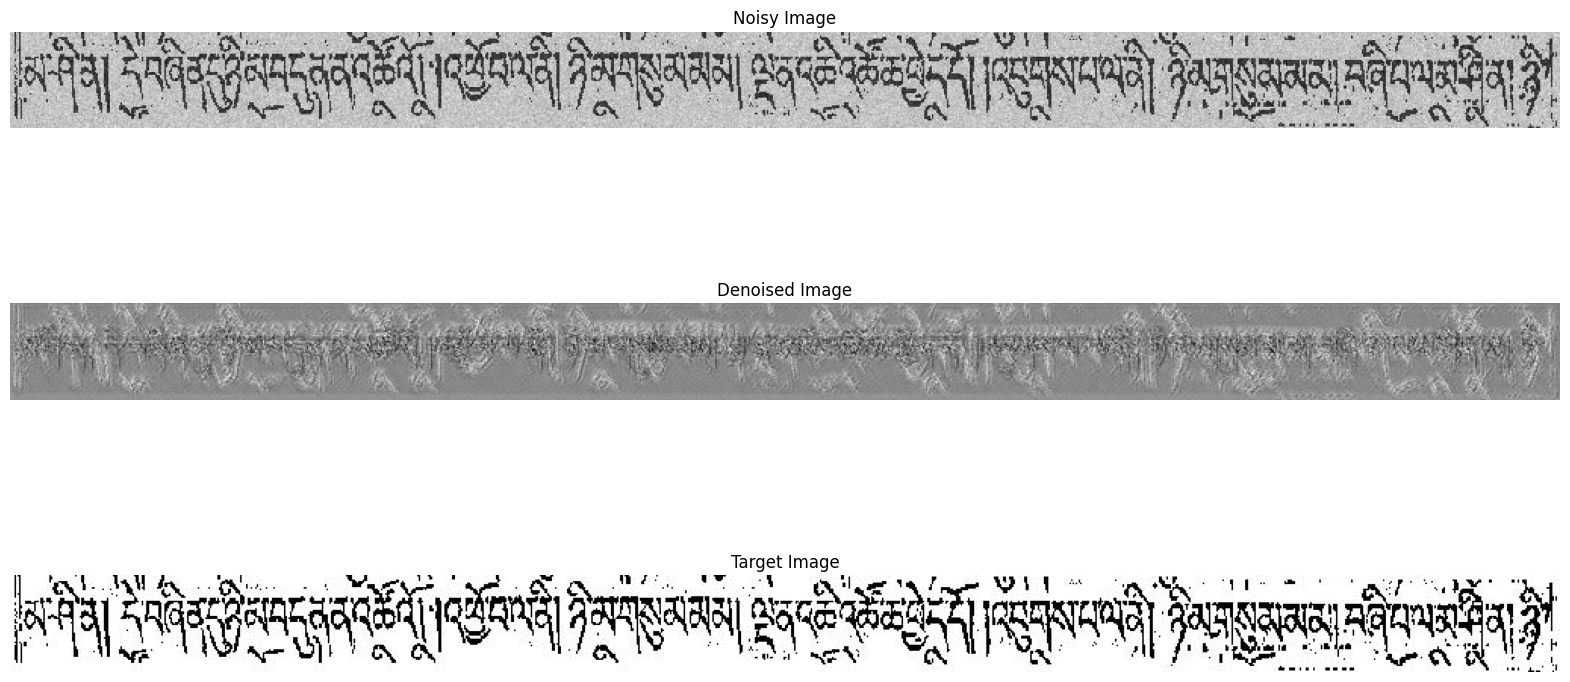

In [ ]:
# Instantiate the model
model = ImageToImageDDPM(l1_weight=1.0, perceptual_weight=0.1)

# Instantiate the trainer
trainer = pl.Trainer(
    default_root_dir='my_custom_logs',  # Custom directory for logs
    precision=16,  # Mixed precision
    accumulate_grad_batches=4,  # Gradient accumulation
    max_epochs=50,  # Number of epochs
    devices=1,
    callbacks=[LearningRateMonitor(logging_interval='epoch')]  # Monitor learning rate
)

# Start training
trainer.fit(model, dataloader)
